In [1]:
import pandas as pd 
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
x_test = pd.read_excel("../Train_Test/Dataset_Separado/x_test_new.xlsx")
x_train = pd.read_excel("../Train_Test/Dataset_Separado/x_train_new.xlsx")
y_test = pd.read_excel("../Train_Test/Dataset_Separado/y_test_new.xlsx")
y_train = pd.read_excel("../Train_Test/Dataset_Separado/y_train_new.xlsx")

In [3]:
R0 =6.371E6 # Radio Terrestre en Metros
long_secuencia = 100 # Longitud de la secuencia o trayectoria.as_integer_ratio


In [4]:
def preproceso_trayectoria(df,R0):
  n_puntos = 100 
  coords = df.values/R0						#	Pasamos a numpy y normalizo a R0
  n_muestras = coords.shape[0]
  x = coords[:,:n_puntos] 						#Columnas 0:99 : x1 a x100
  y = coords[:,n_puntos:2*n_puntos] 	#Columnas 100:199 : y1 a y100
  z = coords[:, 2*n_puntos:3*n_puntos] #Columnas 200:299 : z1 a z100
  
  trayectorias = np.zeros((n_muestras,n_puntos,3))
  trayectorias[:, :, 0] = x
  trayectorias[:, :, 1] = y
  trayectorias[:, :, 2] = z
  return trayectorias

y_train_xyz = preproceso_trayectoria(y_train, R0)
y_test_xyz = preproceso_trayectoria(y_test, R0)

print(f'Formato de y_train_xyz: {y_train_xyz.shape}')

Formato de y_train_xyz: (4104, 100, 3)


* Formato original (300 columnas):

[x1, x2, x3, ..., x100, y1, y2, y3, ..., y100, z1, z2, z3, ..., z100]

* Formato reorganizado (3D array): 

[\
  [ [x1, y1, z1], [x2, y2, z2], ..., [x100, y100, z100] ],  # Trayectoria 1\
  [ [x1, y1, z1], [x2, y2, z2], ..., [x100, y100, z100] ],  # Trayectoria 2 \
  ...\
]

In [5]:
# Elimino Caracteristicas de entrada que no me sirven para el entrenamiento.
x_train_clean = x_train.drop(columns = ['latitude_pos_tx', 'longitude_pos_tx', 'elevation_pos_tx', 'year'])
x_test_clean = x_test.drop(columns = ['latitude_pos_tx', 'longitude_pos_tx', 'elevation_pos_tx', 'year'])

In [6]:
x_test_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1026 entries, 0 to 1025
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   fc [Mhz]   1026 non-null   int64
 1   elevation  1026 non-null   int64
 2   azimuth    1026 non-null   int64
 3   mmdd       1026 non-null   int64
 4   hour       1026 non-null   int64
dtypes: int64(5)
memory usage: 40.2 KB


In [7]:
# Escalado de las caracteristicas de Entrada.
scaler_x = StandardScaler()
x_train_scaled = scaler_x.fit_transform(x_train_clean)
x_test_scaled = scaler_x.transform(x_test_clean)

In [8]:
def construir_modelo(input_shape, seq_length , n_feactures = 3):
  entradas_car = Input(shape=(input_shape,), name = 'Entrada')
  x = Dense(128, activation = 'relu')(entradas_car)
  x = BatchNormalization()(x)
  x = Dropout(0.3)(x)
  x = Dense(256, activation = 'relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.3)(x)
  # Se repite caracteristicas para cada paso de tiempo
  repetir = tf.keras.layers.RepeatVector(seq_length)(x)
  
	# Capa recurrente para secuencias 
  lstm_out = Bidirectional(LSTM(256, return_sequences=True))(repetir)
  lstm_out = BatchNormalization()(lstm_out)
  lstm_out = Dropout(0.4)(lstm_out)
  
  output = Dense(n_feactures, activation='linear', name='Salida')(lstm_out)
  return Model(inputs = entradas_car, outputs = output)
  

In [9]:
x_train_scaled.shape[1]

5

In [10]:
# Construcción del modelo
model = construir_modelo(
  input_shape = x_train_scaled.shape[1],
  seq_length = long_secuencia,
  n_feactures = 3
)

In [11]:
optimizer = Adam(learning_rate = 1E-3, clipvalue = 1.0)
model.compile(optimizer = optimizer, loss = 'mse')

# Callbacks
early_stop = EarlyStopping(
  monitor = 'val_loss',
  patience = 50,
  restore_best_weights = True
)

reduce_lr = ReduceLROnPlateau(
  monitor = 'val_loss', 
  patience = 20,
  factor = 0.5,
  min_lr = 1E-6
)

# Entrenamiento 
history = model.fit(
  x_train_scaled,
  y_train_xyz,
  epochs = 200,
  batch_size = 32,
  validation_split = 0.1,
  callbacks = [early_stop, reduce_lr]
)

Epoch 1/200
116/116 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - loss: 2.0253 - val_loss: 0.0165 - learning_rate: 0.0010
Epoch 2/200
116/116 ━━━━━━━━━━━━━━━━━━━━ 87s 751ms/step - loss: 0.3813 - val_loss: 0.0096 - learning_rate: 0.0010
Epoch 3/200
116/116 ━━━━━━━━━━━━━━━━━━━━ 160s 906ms/step - loss: 0.1158 - val_loss: 0.0081 - learning_rate: 0.0010
Epoch 4/200
116/116 ━━━━━━━━━━━━━━━━━━━━ 108s 933ms/step - loss: 0.0430 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 5/200
116/116 ━━━━━━━━━━━━━━━━━━━━ 106s 917ms/step - loss: 0.0225 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 6/200
116/116 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - loss: 0.0159 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 7/200
116/116 ━━━━━━━━━━━━━━━━━━━━ 101s 645ms/step - loss: 0.0126 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 8/200
116/116 ━━━━━━━━━━━━━━━━━━━━ 83s 712ms/step - loss: 0.0110 - val_loss: 0.0057 - learning_rate: 0.0010
Epoch 9/200
116/116 ━━━━━━━━━━━━━━━━━━━━ 77s 660ms/step - loss: 0.0098 - val_loss: 0.004

In [12]:
# Evaluaciones y Predicciones
test_loss = model.evaluate(x_test_scaled, y_test_xyz)
print(f'Test Loss: {test_loss: .4f}')
# Predecir trayectorias completas
y_pred = model.predict(x_test_scaled)

def cartesiano_a_geo(xyz, R0):
  x,y,z, = xyz[..., 0], xyz[..., 1], xyz[..., 2]
  # pasamos a coordenadas Esfericas
  r = np.sqrt(x**2 + y**2 + z**2) * R0
  lat = np.degrees(np.arcsin(z/r*R0))
  lon = np.degrees(np.arctan2(y,x))
  # Obtenemos la altura sobre el nivel del mar
  alt = r - R0
  return np.stack([lat, lon, alt], axis=-1)

geo_pred = cartesiano_a_geo(y_pred, R0)
geo_true = cartesiano_a_geo(y_test_xyz, R0)

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 1.1716e-04
Test Loss:  0.0001
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step


### Clipvalue
El parámetro **clipvalue** se usa para evitar que los gradientes exploten durante el entrenamiento de la red neuronal.


In [13]:
# Visualización de los Resultados
def plot_trayectorias(true_tray, pred_tray, idx = 0):
  fig = plt.figure(figsize = (15,10))
  ax1 = fig.add_subplot(121, projection = '3d')
  ax1.plot(true_tray[idx, :,0],true_tray[idx, :, 1], true_tray[idx, :, 2], 'b-', label = 'Real')
  ax1.plot(pred_tray[idx, :,0],pred_tray[idx, :, 1], pred_tray[idx, :, 2], 'r--', label = 'Predicha')
  ax1.set_xlabel('X [m]')
  ax1.set_ylabel('Y [m]')
  ax1.set_zlabel('Z [m]')
  ax1.legend()
  ax1.set_title('Comparación de Trayectorias Real y Predic')
  
  ax2 = fig.add_subplot(322)
  ax2.plot(true_tray[idx, :, 0], true_tray[idx,: , 1], 'b-', label='Real')
  ax2.plot(pred_tray[idx, :, 0], pred_tray[idx, :, 1], 'r--', label = 'Predicha')
  ax2.set_xlabel('X [m]')
  ax2.set_ylabel('Y [m]')
  ax2.legend()
  ax2.set_title('Proyección XY')
  
  ax3 = fig.add_subplot(324)
  ax3.plot(true_tray[idx, :, 0], true_tray[idx, :, 2], 'b-', label ='Real')
  ax3.plot(pred_tray[idx, :, 0], pred_tray[idx, :, 2], 'r--', label = 'Predicha')
  ax3.set_xlabel('X [m]')
  ax3.set_ylabel('Z [m]')
  ax3.set_title('Proyección XZ')
  
  ax4 = fig.add_subplot(326)
  ax4.plot(true_tray[idx, :, 1], true_tray[idx, :, 2], 'b-', label = 'True')
  ax4.plot(pred_tray[idx, :, 1], pred_tray[idx,:, 2], 'r--', label='Predicha')
  ax4.set_xlabel('Y [m]')
  ax4.set_ylabel('Z [m]')
  ax4.set_title('Proyección YZ')
  
  plt.tight_layout()
  plt.show()

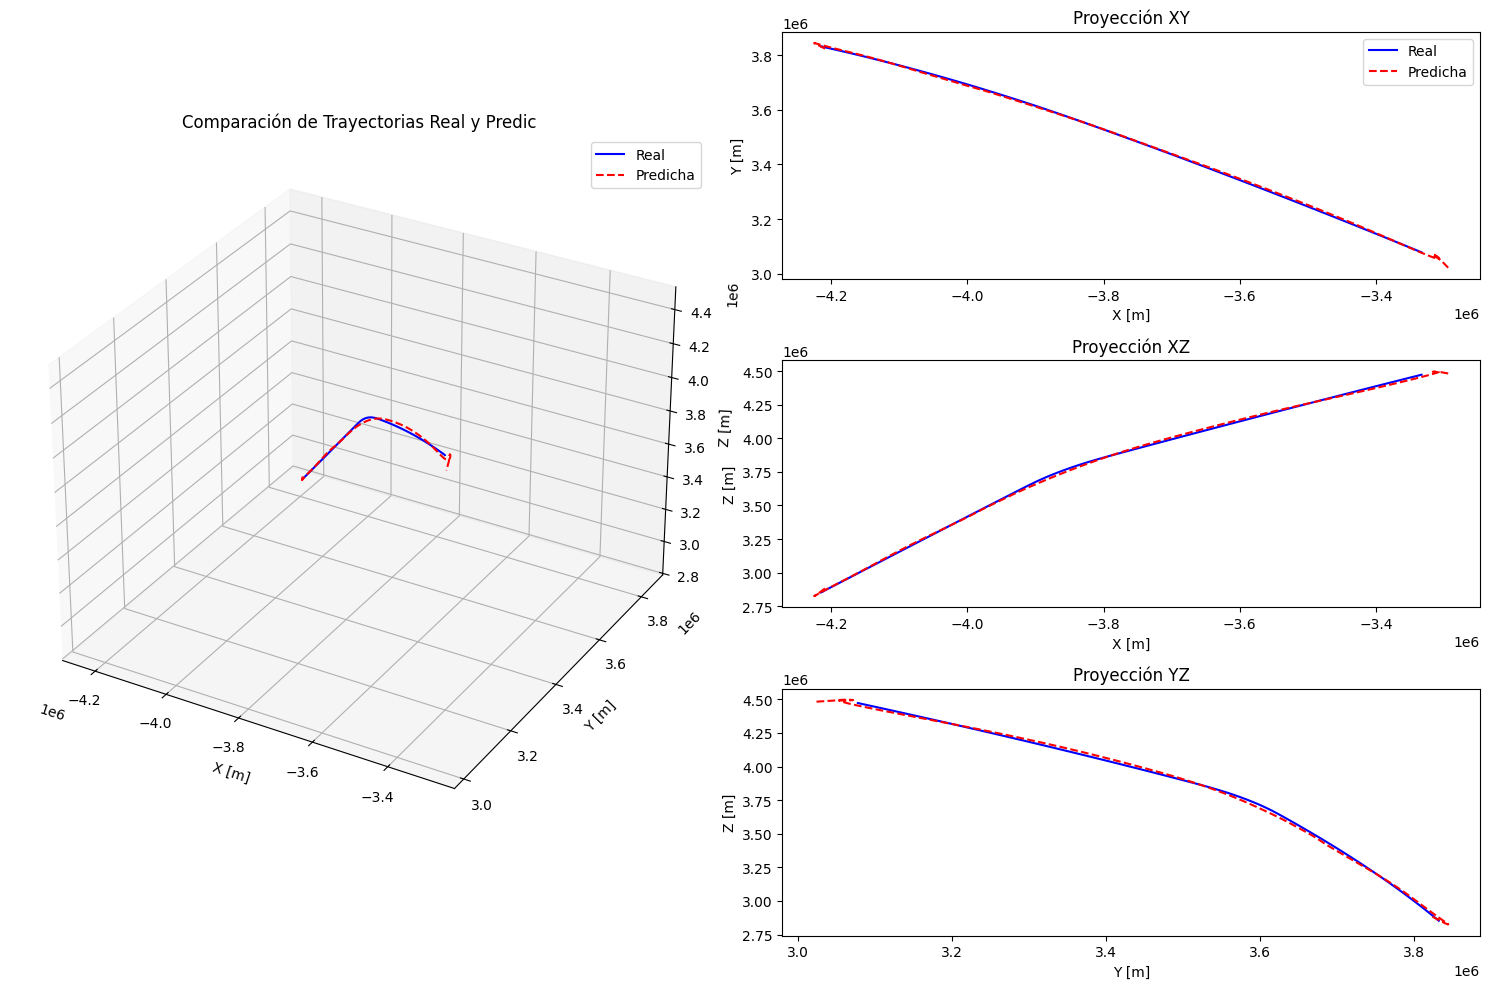

In [25]:
plot_trayectorias(y_test_xyz* R0, y_pred * R0, idx = 33)

In [ ]:
import pickle
from tensorflow.keras.models import save_model

# Guardar el modelo
save_model(model, '../modelos_entrenamiento/PRUEBA/mod_xyz_R0.keras')

# Guardar los scalers
with open('../modelos_entrenamiento/PRUEBA/scaler_x.pkl', 'wb') as f:
    pickle.dump(scaler_x, f)

# Guardar información adicional que puedas necesitar
model_info = {
    'R0': R0,
    'input_columns': list(x_train.columns),
    'output_sequence_length': 100
}

with open('../modelos_entrenamiento/PRUEBA/model_info.pkl', 'wb') as f:
    pickle.dump(model_info, f)